<a href="https://colab.research.google.com/github/venkatnarayankaranam/IIIT-FMML-ASSIGNMENT/blob/main/Module9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-14 15:53:01--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.225.4.72, 13.225.4.25, 13.225.4.109, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.225.4.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   281MB/s    in 0.2s    

2024-05-14 15:53:01 (281 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


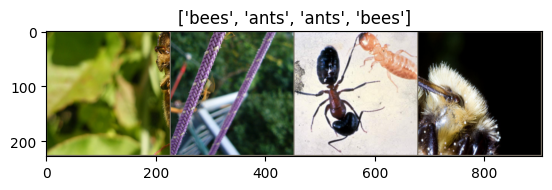

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.6718 Acc: 0.6557

Epoch 1/4
----------
Loss: 0.4860 Acc: 0.7992

Epoch 2/4
----------
Loss: 0.7529 Acc: 0.7418

Epoch 3/4
----------
Loss: 0.4468 Acc: 0.8033

Epoch 4/4
----------
Loss: 0.5320 Acc: 0.7910



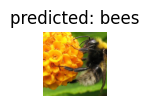

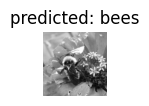

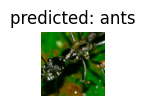

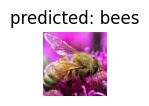

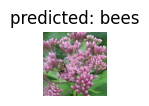

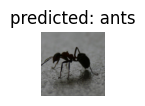

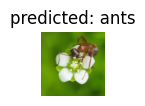

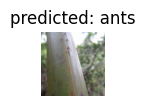

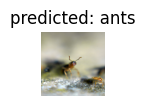

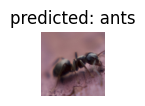

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?
**ANSWER:-**Increased Diversity: Data augmentation techniques artificially increase the diversity of the training dataset by generating new samples from existing ones. This helps expose the model to a wider range of variations and scenarios that it might encounter during inference, leading to better generalization performance.

Robustness to Variability: Real-world data often exhibits variability in terms of lighting conditions, orientations, scales, and other factors. By augmenting the training data with transformations such as resizing, cropping, and rotation, the model learns to be robust to these variations, making it more reliable when deployed in diverse environments.

Regularization: Data augmentation acts as a form of regularization by introducing noise and variations into the training process. This helps prevent overfitting by discouraging the model from memorizing specific training examples and instead encourages it to learn more robust and generalizable features.

Reduced Dependency on Large Datasets: Augmentation allows practitioners to effectively increase the size of their training dataset without collecting additional labeled samples. This is particularly beneficial in scenarios where obtaining large amounts of labeled data is challenging or expensive.

Better Utilization of Available Data: In many cases, the available training data may be limited in quantity. Data augmentation allows practitioners to make the most out of the available data by generating additional samples, thereby maximizing the information extracted from the dataset.

Improved Performance on Imbalanced Datasets: Data augmentation can help address class imbalances in the training data by generating synthetic samples for underrepresented classes. This can lead to more balanced training datasets and improved performance, especially for classification tasks with imbalanced class distributions.

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

**ANSWER:-**Dataset: Choose a suitable dataset for training the ResNet model. Common choices include CIFAR-10, CIFAR-100, ImageNet, or custom datasets.

Model Architecture: Define the ResNet architecture. You can choose from different variants of ResNet, such as ResNet-18, ResNet-34, ResNet-50, etc., depending on the complexity of the task and available resources.

Data Preprocessing: Preprocess the dataset, including resizing, normalization, and data augmentation (if necessary).

Model Training: Train the ResNet model from scratch using the chosen dataset. This involves selecting appropriate hyperparameters (learning rate, batch size, number of epochs, etc.) and monitoring the training process using metrics such as loss and accuracy.

Evaluation: Evaluate the trained model on a separate validation or test set to assess its performance in terms of accuracy, precision, recall, etc.


3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?

**ANSWER:-**The performance of a pretrained ResNet model on a significantly different dataset, such as the ants vs. bees dataset, would depend on several factors:

Domain Similarity: If the dataset the ResNet model was pretrained on is significantly different from the ants vs. bees dataset in terms of domain, content, or characteristics, the pretrained features may not generalize well to the new dataset. For example, if the pretrained model was trained on natural images containing diverse objects, it may still capture generic features like edges, textures, and shapes that are useful for image classification tasks, including ants vs. bees. However, if the domain gap is too large (e.g., medical images or satellite imagery), the pretrained features may not be directly applicable, and the model might require additional fine-tuning or transfer learning techniques to adapt to the new domain.

Task Relevance: The performance of the pretrained model on the ants vs. bees dataset would also depend on the relevance of the pretrained features to the specific task at hand. While some features learned by the pretrained model may be useful for distinguishing between different types of objects or scenes, other features may be less relevant or even detrimental to the task of classifying ants vs. bees. In such cases, fine-tuning the pretrained model or using techniques like feature extraction may be necessary to adapt the model to the new task.

Dataset Size and Complexity: The size and complexity of the ants vs. bees dataset would also influence the effectiveness of the pretrained model. If the dataset is small or if the classes are highly similar or nuanced, the pretrained features may provide a good initialization point for training a new classifier, but additional training on the target dataset would likely be needed to achieve optimal performance. On the other hand, if the dataset is large and diverse, the pretrained features may already capture many relevant patterns and distinctions, leading to better performance with minimal fine-tuning.

Fine-Tuning and Transfer Learning: Even if the pretrained model was trained on a significantly different dataset, techniques like fine-tuning and transfer learning can still be effective in leveraging the pretrained features for the ants vs. bees classification task. Fine-tuning involves unfreezing some or all of the layers in the pretrained model and continuing training on the target dataset with a lower learning rate. Transfer learning involves using the pretrained model as a feature extractor, where the output of one of the intermediate layers of the model is used as input to a new classifier trained specifically for the target task.
